In [1]:
#importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import datasets, metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

### Model 4:

Model will evaluate impact on Sale Price of:
- Total sqft (feature engineering)
- Condition
- Quality
- Interaction of Condition/Quality (feature engineering)
- Total # of Bathrooms (feature engineering)
- Bedrooms (proxy Above-Ground Bedrooms)
- Month sold
- Neighborhood

### Feature Engineering

**Bathrooms**

**1st assumption:** house price is dependent on the total number of bathrooms in the house. This will be calculated as the sum of:

* Full Bathrooms
* Basement Half Bathrooms
* Basement Full Bathrooms
* Half Bathrooms

In [2]:
%store -r df_no_na
df_no_na["Bathrooms"] = df_no_na["Full Bath"] + df_no_na["Bsmt Half Bath"] + df_no_na["Bsmt Full Bath"] + df_no_na["Half Bath"]

In [3]:
#repeat for test data
%store -r df_test_no_na
df_test_no_na["Bathrooms"] = df_test_no_na["Full Bath"] + df_test_no_na["Bsmt Half Bath"] + df_test_no_na["Bsmt Full Bath"] + df_test_no_na["Half Bath"]

<br>

**Month Sold Dummy (M_< >)**

**2nd assumption:** there is, on average over the years of data, seasonality to sales. 

In [5]:
month_sold_impact = df_no_na.groupby(['Mo Sold'])["SalePrice"].aggregate(
    ["mean"]).reset_index().sort_values("mean", ascending=False)
month_sold_impact

,Mo Sold,mean
0,1,195126.303797
8,9,188990.761468
6,7,188571.514851
7,8,186927.359281
10,11,184377.495146
5,6,182662.798295
11,12,182459.615385
4,5,180332.369650
9,10,179334.471545
1,2,177626.519231


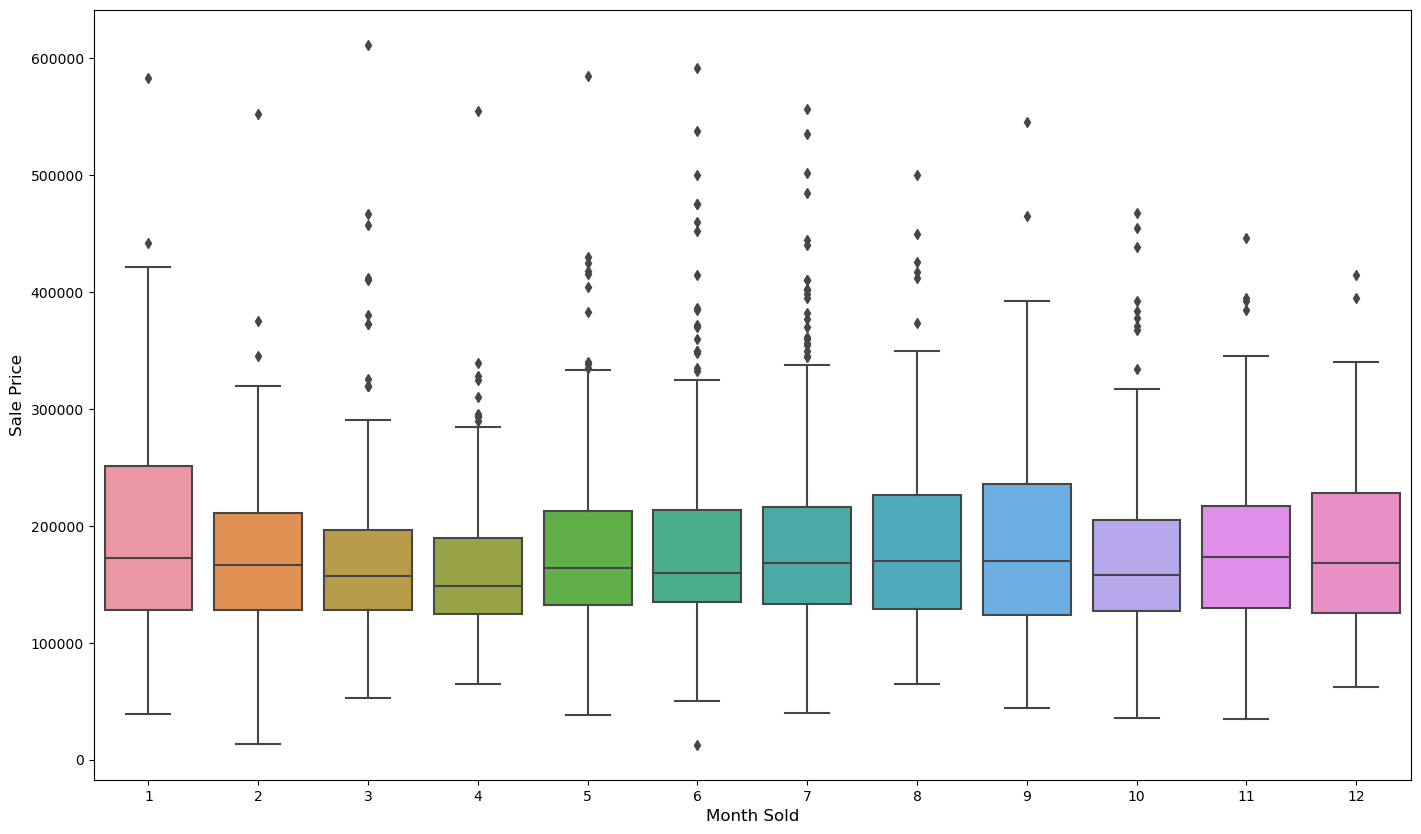

In [8]:
#df_no_na.plot.scatter(x = 'Mo Sold', y = 'SalePrice');

plt.figure(figsize=(17,10))
monthsale = sns.boxplot(x='Mo Sold', y='SalePrice', data=df_no_na)
plt.xlabel('Month Sold', fontsize=12)
plt.ylabel('Sale Price', fontsize=12);

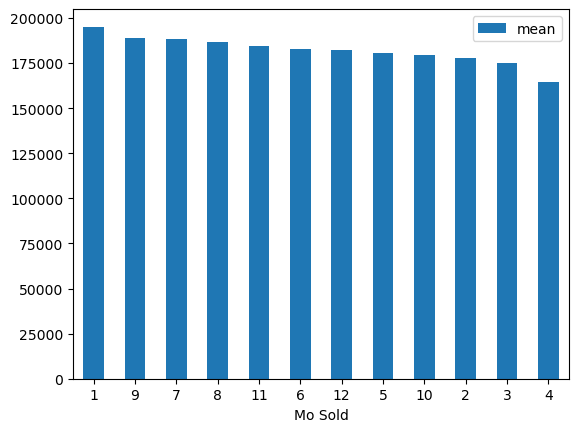

In [7]:
month_sold_impact.plot.bar(x='Mo Sold', y='mean', rot=0);

Looking at average Sale Price by month (across years), there looks to be some seasonality in Sale Price. March seems to be the best month to get a good deal on a house, while January seems to be the most expensive.

In [9]:
monthsale_summary = df_no_na["Mo Sold"].value_counts(normalize=True).to_frame("pct sales")
monthsale_summary

,pct sales
6,0.171791
7,0.147877
5,0.125427
4,0.101025
3,0.081503
8,0.081503
10,0.060029
9,0.053197
2,0.050756
11,0.050268


If you're looking to buy a house, June is a busy time for home sales, while December and January are the slowest. 
Average sale prices in March look to be lower than the rest of the year. While they peak in January and September.

<br>

**Month Dummy (M_< >)**

In [10]:
enc = OneHotEncoder()

In [11]:
cols_ = ["Mo Sold"]
column_name_ = []
for col in cols_:
    column_name_ += [f"{col[0]}_{cat}" for cat in list(df_no_na[col].unique())]
column_name_

enc_data_prep_ = enc.fit_transform(df_no_na[['Mo Sold']]).toarray()
enc_data = pd.DataFrame(enc_data_prep_, columns=column_name_)

In [12]:
df_no_na_4 = df_no_na.join(enc_data)

<br>

**Neighborhood Dummy (N_< >)**

In [147]:
#encode the Neighborhood data
cols = ["Neighborhood"]
column_name = []
for col in cols:
    column_name += [f"{col[0]}_{cat}" for cat in list(df_no_na[col].unique())]
column_name

enc_data_prep = enc.fit_transform(df_no_na[['Neighborhood']]).toarray()
enc_data_1 = pd.DataFrame(enc_data_prep, columns=column_name)
df_no_na_5 = df_no_na_4.join(enc_data_1)
df_no_na_5.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,N_SWISU,N_NoRidge,N_ClearCr,N_Blmngtn,N_BrkSide,N_NPkVill,N_Blueste,N_GrnHill,N_Greens,N_Landmrk
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [153]:
df_no_na_5["N_Blmngtn"]=0
df_no_na_5["N_Blueste"]=0
df_no_na_5["N_BrkSide"]=0
df_no_na_5["N_Greens"]=0
df_no_na_5["N_NPkVill"]=0

In [170]:
df_test_no_na_4["Total_SF"] = df_test_no_na_4[["Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Garage Area"]].sum(axis=1) 

In [185]:
df_test_no_na_4["Qual_cond"] = df_test_no_na_4["Overall Qual"] * df_test_no_na_4["Overall Cond"]

In [186]:
#repeat for test data
cols_ = ["Mo Sold"]
column_name_ = []
for col in cols_:
    column_name_ += [f"{col[0]}_{cat}" for cat in list(df_test_no_na[col].unique())]
column_name_

enc_data_prep_test = enc.fit_transform(df_test_no_na[['Mo Sold']]).toarray()
enc_data_test = pd.DataFrame(enc_data_prep_test, columns=column_name_)

In [169]:
df_test_no_na_4 = df_test_no_na.join(enc_data_test)

In [187]:
cols = ["Neighborhood"]
column_name_area = []
for col in cols:
    column_name_area += [f"{col[0]}_{cat}" for cat in list(df_test_no_na[col].unique())]
column_name_area

enc_data_prep_area = enc.fit_transform(df_test_no_na[['Neighborhood']]).toarray()
enc_data_area = pd.DataFrame(enc_data_prep_area, columns=column_name_area)
df_test_no_na_5 = df_test_no_na_4.join(enc_data_1)
df_test_no_na_5.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,N_SWISU,N_NoRidge,N_ClearCr,N_Blmngtn,N_BrkSide,N_NPkVill,N_Blueste,N_GrnHill,N_Greens,N_Landmrk
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Model - Linear Regression

In [160]:
columns_to_drop_4 = ['Id',             'PID',     'MS SubClass',
             'MS Zoning',    'Lot Frontage',        'Lot Area',
                'Street',           'Alley',       'Lot Shape',
          'Land Contour',       'Utilities',      'Lot Config',
            'Land Slope',    'Neighborhood',     'Condition 1',
           'Condition 2',       'Bldg Type',     'House Style',      
        'Year Remod/Add',      'Roof Style',       'Roof Matl',
          'Exterior 1st',    'Exterior 2nd',    'Mas Vnr Type',
          'Mas Vnr Area',      'Exter Qual',      'Exter Cond',
            'Foundation',       'Bsmt Qual',       'Bsmt Cond',
         'Bsmt Exposure',  'BsmtFin Type 1',    'BsmtFin SF 1',
        'BsmtFin Type 2',    'BsmtFin SF 2',     'Bsmt Unf SF',
         'Total Bsmt SF',         'Heating',      'Heating QC',
           'Central Air',      'Electrical',      '1st Flr SF',
            '2nd Flr SF', 'Low Qual Fin SF',     'Gr Liv Area',
        'Bsmt Full Bath',  'Bsmt Half Bath',       'Full Bath',
             'Half Bath',   'Kitchen AbvGr',
          'Kitchen Qual',   'TotRms AbvGrd',      'Functional',
            'Fireplaces',    'Fireplace Qu',     'Garage Type',
         'Garage Yr Blt',   'Garage Finish',     'Garage Cars',
           'Garage Area',     'Garage Qual',     'Garage Cond',
           'Paved Drive',    'Wood Deck SF',   'Open Porch SF',
        'Enclosed Porch',      '3Ssn Porch',    'Screen Porch',
             'Pool Area',         'Pool QC',           'Fence',
          'Misc Feature',        'Misc Val',      'Year Built',
               'Yr Sold',       'Sale Type',         "Mo Sold",
            'Transform_SF']

features_4 = [col for col in df_no_na_5.columns if col not in columns_to_drop_4]

In [171]:
#test features - removing Sale Price column name

columns_to_drop_4_test = ['Id',             'PID',     'MS SubClass',
             'MS Zoning',    'Lot Frontage',        'Lot Area',
                'Street',           'Alley',       'Lot Shape',
          'Land Contour',       'Utilities',      'Lot Config',
            'Land Slope',    'Neighborhood',     'Condition 1',
           'Condition 2',       'Bldg Type',     'House Style',      
        'Year Remod/Add',      'Roof Style',       'Roof Matl',
          'Exterior 1st',    'Exterior 2nd',    'Mas Vnr Type',
          'Mas Vnr Area',      'Exter Qual',      'Exter Cond',
            'Foundation',       'Bsmt Qual',       'Bsmt Cond',
         'Bsmt Exposure',  'BsmtFin Type 1',    'BsmtFin SF 1',
        'BsmtFin Type 2',    'BsmtFin SF 2',     'Bsmt Unf SF',
         'Total Bsmt SF',         'Heating',      'Heating QC',
           'Central Air',      'Electrical',      '1st Flr SF',
            '2nd Flr SF', 'Low Qual Fin SF',     'Gr Liv Area',
        'Bsmt Full Bath',  'Bsmt Half Bath',       'Full Bath',
             'Half Bath',   'Kitchen AbvGr',
          'Kitchen Qual',   'TotRms AbvGrd',      'Functional',
            'Fireplaces',    'Fireplace Qu',     'Garage Type',
         'Garage Yr Blt',   'Garage Finish',     'Garage Cars',
           'Garage Area',     'Garage Qual',     'Garage Cond',
           'Paved Drive',    'Wood Deck SF',   'Open Porch SF',
        'Enclosed Porch',      '3Ssn Porch',    'Screen Porch',
             'Pool Area',         'Pool QC',           'Fence',
          'Misc Feature',        'Misc Val',      'Year Built',
               'Yr Sold',       'Sale Type',         "Mo Sold",
             'SalePrice', 'Transform_SalePrice' ]

In [162]:
df_no_na_6 = df_no_na_5[features_4] #create subset dataframe for analysis

In [188]:
#repeat for test data
features_4_test = [col for col in df_test_no_na_5.columns if col not in columns_to_drop_4_test]
df_test_no_na_6 = df_test_no_na_5[features_4_test]

In [181]:
df_no_na_6.loc[0,"N_Greens"]=0
df_no_na_6.loc[0,"N_GrnHill"]=0
df_no_na_6.loc[0,"N_Landmrk"]=0


In [182]:
df_no_na_6.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_20396/1211205188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_6.dropna(how = "any", inplace = True)


In [190]:
#repeat for test data
df_test_no_na_6.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_20396/776999309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_6.dropna(how = "any", inplace = True)


In [184]:
X_4 = df_no_na_6.drop(columns = ["SalePrice", 'M_1', "N_Sawyer", "Transform_SalePrice"])
y_4 = df_no_na_6["SalePrice"]

In [194]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X_4, y_4, random_state=42)

In [192]:
#test data 
X_4_to_test = df_test_no_na_6.drop(columns = ['M_1', "N_Sawyer"])

In [197]:
ss = StandardScaler()
#ss.fit(X_train)
X4_train = ss.fit_transform(X4_train)
X4_test = ss.transform(X4_test)

In [199]:
X_4_test = ss.transform(X_4_to_test.values)

In [201]:
lr4 = LinearRegression()

In [202]:
lr4.fit(X4_train,y4_train)

LinearRegression()

In [203]:
lr4.score(X4_train, y4_train)

0.790307671475853

In [204]:
y_4_pred = lr4.predict(X4_test) #validate model

In [205]:
rmse_4 = np.sqrt(mean_squared_error(y4_test, y_4_pred))

In [206]:
print(f"train_data r^2: {lr4.score(X4_train,y4_train)}.")
print(f"validation_data r^2: {lr4.score(X4_test, y4_test)}.")
print(f"root mean squared error: {rmse_4}.")

train_data r^2: 0.790307671475853.
validation_data r^2: 0.8037246547526352.
root mean squared error: 34671.35609152645.


In [208]:
%store -r df_test
submission4 = pd.DataFrame(df_test, columns=["Id"])
submission4["SalePrice"] = lr4.predict(X_4_test)

In [210]:
submission4.to_csv('./datasets/submission4.csv', index=False)

### Model Validation

In [217]:
for_corr = df_no_na_6.drop(columns = ["Transform_SalePrice"])

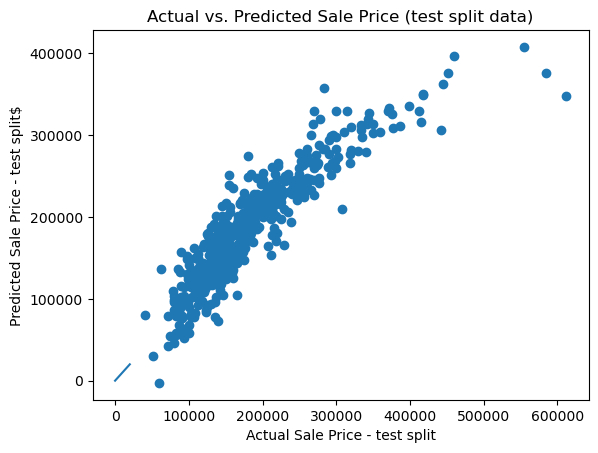

In [211]:
plt.scatter(y4_test, y_4_pred)
plt.plot(range(20000), range(20000))

plt.xlabel("Actual Sale Price - test split")
plt.ylabel("Predicted Sale Price - test split$")
plt.title("Actual vs. Predicted Sale Price (test split data)")

plt.show()

**Note:** some odd outlier data toward the top of the Actual Sale Price values, indicating a non-linear distributino of errors.

In [220]:
lasso_4 = Lasso(alpha=1)
lasso_4.fit(X4_train, y4_train)

Lasso(alpha=1)

In [221]:
print('R2 training data', round(lasso_4.score(X4_train, y4_train), 2))
print('R2 test data', round(lasso_4.score(X4_test, y4_test), 2))

R2 training data 0.79
R2 test data 0.8


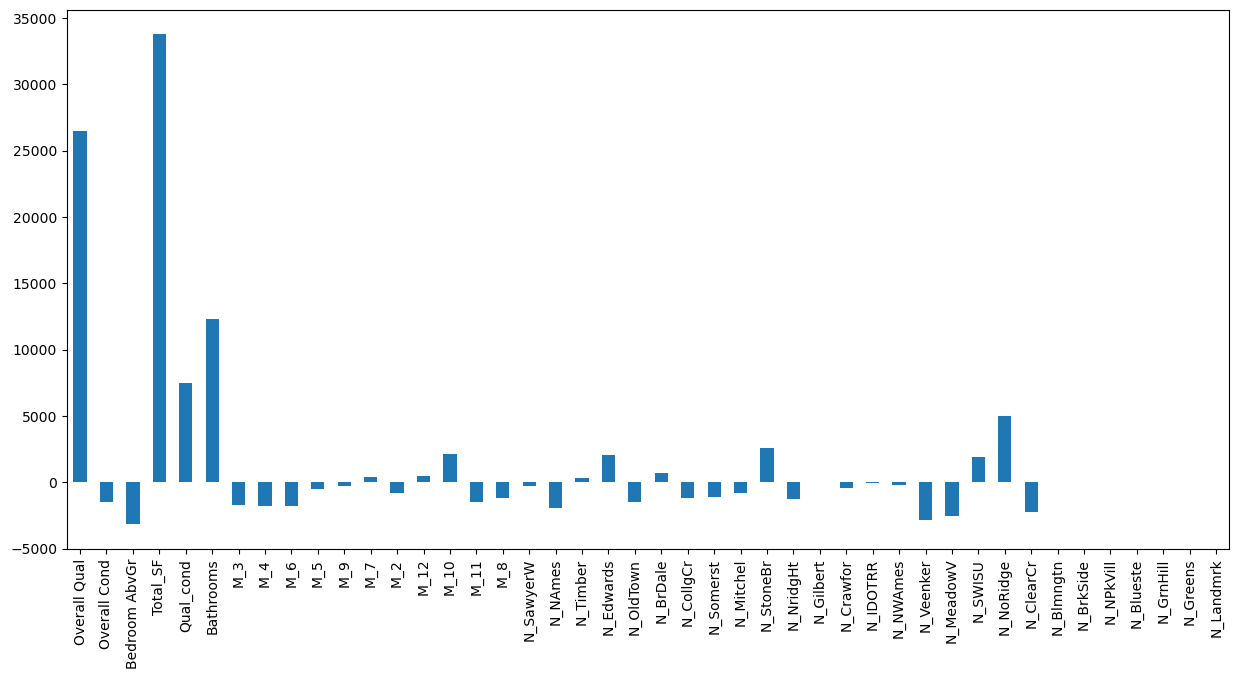

In [225]:
pd.Series(lasso_4.coef_, index=X_4.columns.values).plot.bar(figsize = (15, 7));

In [222]:
ridge_4 = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [223]:
ridge_4.fit(X4_train, y4_train)
ridge_scores = cross_val_score(ridge_4, X4_train, y4_train, cv = 3)
ridge_scores.mean()

0.752001905225419